<a href="https://colab.research.google.com/github/whyranox3/Hacksa/blob/master/fityou0616.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 필요한 라이브러리 불러오기
from IPython.display import Image as IPyImage, display
from PIL import Image
import os
import torch
from torch.autograd import Variable
import numpy as np
from torchvision import transforms
from google.colab import files

In [2]:
# 사용자 입력 받기
height = int(input("키(cm)를 입력하세요: "))
weight = int(input("몸무게(kg)를 입력하세요: "))

키(cm)를 입력하세요: 155
몸무게(kg)를 입력하세요: 50


In [3]:
# 키 구간
if 150 <= height < 160:
    height_code = 'A'
elif 160 <= height < 170:
    height_code = 'B'
elif 170 <= height < 180:
    height_code = 'C'
else:
    height_code = 'C'  # 예외 처리

In [4]:
# BMI 계산
height_m = height / 100
bmi = weight / (height_m ** 2)

In [5]:
# 체중 구간
if bmi < 18.5:
    weight_code = 'under'
elif bmi < 25:
    weight_code = 'normal'
else:
    weight_code = 'over'

체형: A_normal.jpg


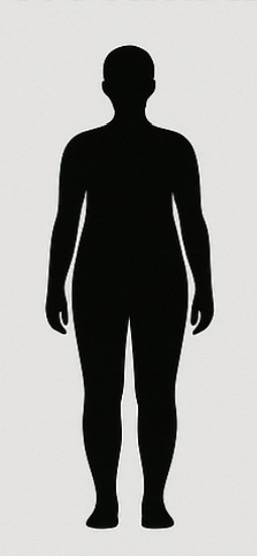

In [6]:
# 아바타 이미지 선택
filename = f"{height_code}_{weight_code}.jpg"
avatar_path = f"/content/{filename}"
print(f"체형: {filename}")

avatar = Image.open(avatar_path).convert("RGBA")
display(avatar)

In [7]:
position_table = {
    "A_under": {
        "upper": {"center": (120, 183), "size": (160, 170)},
        "lower": {"center": (120, 305), "size": (150, 170)},
    },
    "A_normal": {
        "upper": {"center": (120, 183), "size": (165, 175)},
        "lower": {"center": (120, 305), "size": (155, 175)},
    },
    "A_over": {
        "upper": {"center": (110, 140), "size": (170, 180)},
        "lower": {"center": (110, 320), "size": (160, 180)},
    },
    "B_under": {
        "upper": {"center": (120, 183), "size": (170, 180)},
        "lower": {"center": (120, 305), "size": (160, 180)},
    },
    "B_normal": {
        "upper": {"center": (120, 145), "size": (175, 185)},
        "lower": {"center": (120, 330), "size": (165, 185)},
    },
    "B_over": {
        "upper": {"center": (120, 150), "size": (180, 190)},
        "lower": {"center": (120, 340), "size": (170, 190)},
    },
    "C_under": {
        "upper": {"center": (130, 150), "size": (180, 190)},
        "lower": {"center": (130, 350), "size": (170, 190)},
    },
    "C_normal": {
        "upper": {"center": (130, 170), "size": (185, 195)},
        "lower": {"center": (130, 350), "size": (175, 195)},
    },
    "C_over": {
        "upper": {"center": (130, 160), "size": (190, 200)},
        "lower": {"center": (130, 370), "size": (180, 200)},
    },
}


In [8]:
# 체형 코드 추출
code = filename.split('.')[0]  # 예: 'B_normal'

In [9]:
# 위치/크기 테이블에서 해당 정보 가져오기
upper_info = position_table[code]["upper"]
lower_info = position_table[code]["lower"]

In [10]:
# U-2-Net 다운로드 및 준비
!git clone https://github.com/xuebinqin/U-2-Net
%cd U-2-Net
!pip install gdown opencv-python pillow numpy

%cd saved_models
!gdown --id 1rbSTGKAE-MTxBYHd-51l2hMOQPT_7EPy
%cd ..

Cloning into 'U-2-Net'...
remote: Enumerating objects: 1077, done.
remote: Counting objects: 100% (422/422), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 1077 (delta 398), reused 380 (delta 380), pack-reused 655 (from 2)
Receiving objects: 100% (1077/1077), 66.95 MiB | 37.46 MiB/s, done.
Resolving deltas: 100% (539/539), done.
/content/U-2-Net
/content/U-2-Net/saved_models
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1rbSTGKAE-MTxBYHd-51l2hMOQPT_7EPy
To: /content/U-2-Net/saved_models/u2netp.pth
100% 4.68M/4.68M [00:00<00:00, 210MB/s]
/content/U-2-Net


In [11]:
# 옷 저장 디렉토리 준비
upper_dir = "outputs/upper_clothes"
lower_dir = "outputs/lower_clothes"
os.makedirs(upper_dir, exist_ok=True)
os.makedirs(lower_dir, exist_ok=True)

In [12]:
# 상의 업로드
print("상의 이미지를 업로드해주세요")
uploaded_upper = files.upload()
upper_filename = "shirt.jpg"

# 업로드된 상의 파일 경로 추출
upper_input_path = None # 나중에 누끼 처리에 사용
for upper_filename in uploaded_upper:
    upper_input_path = os.path.join(upper_dir, upper_filename)
    Image.open(upper_filename).save(upper_input_path)
    print(f"상의 저장 완료: {upper_input_path}")

상의 이미지를 업로드해주세요


Saving tshirt.jpg to tshirt.jpg
상의 저장 완료: outputs/upper_clothes/tshirt.jpg


In [13]:
# 하의 업로드
print("하의 이미지를 업로드해주세요")
uploaded_lower = files.upload()
lower_filename = "pants.jpg"

for fname in uploaded_lower:
    lower_input_path = os.path.join(lower_dir, fname)
    Image.open(fname).save(lower_input_path)
    print(f"하의 저장 완료: {lower_input_path}")

하의 이미지를 업로드해주세요


Saving hpants.jpg to hpants.jpg
하의 저장 완료: outputs/lower_clothes/hpants.jpg


In [14]:
# U-2-Net 관련 모듈
from model import U2NETP
from u2net_test import normPRED, save_output
from data_loader import RescaleT, ToTensorLab, ToTensor

# U-2-Net 누끼 처리 함수
def process_with_u2net(input_path, output_dir, model_name='u2net'):
  print(f"[U-2-Net 처리 시작] {input_path}")

In [15]:
# 모델 로딩
model_dir = 'saved_models/u2netp.pth'
net = U2NETP(3, 1)
net.load_state_dict(torch.load(model_dir, map_location='cpu'))
net.eval()

U2NETP(
  (stage1): RSU7(
    (rebnconvin): REBNCONV(
      (conv_s1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (rebnconv1): REBNCONV(
      (conv_s1): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv2): REBNCONV(
      (conv_s1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv3): REBNCONV(
      (conv_s1): Conv2d(16, 16, 

In [16]:
import torchvision.transforms as transforms
from data_loader import RescaleT, ToTensorLab
from u2net_test import normPRED, save_output
from PIL import Image
import numpy as np
import os

In [17]:
# 전처리 transform 정의
transform = transforms.Compose([
    RescaleT(320),
    ToTensorLab(flag=0)
])

In [18]:
def save_output(image_path, pred, d_dir, file_name=None):
    pred = pred.squeeze()
    pred = pred.cpu().data.numpy()
    mask = Image.fromarray((pred * 255).astype(np.uint8)).convert('L')

    # 이미지 크기 맞추기 (핵심!)
    original = Image.open(image_path).convert("RGBA")
    mask = mask.resize(original.size)  # 💡 여기가 핵심

    if file_name is None:
        file_name = os.path.basename(image_path)
    full_path = os.path.join(d_dir, file_name)

    empty = Image.new("RGBA", original.size, (0, 0, 0, 0))
    result = Image.composite(original, empty, mask)

    result.save(full_path)

In [19]:
# 누끼 처리 함수
def inference_with_u2net(image_path, output_dir):
    # 이미지 불러오기
    img = np.array(Image.open(image_path).convert('RGB'))
    sample = {'image': img, 'label': img, 'imidx': np.array([0])}

    transformed = transform(sample)  # 이걸 먼저 해야 transformed가 생김

    img_tensor = transformed['image'].unsqueeze(0).type(torch.FloatTensor)

    # 추론
    with torch.no_grad():
        d1, _, _, _, _, _, _ = net(img_tensor)
        pred = d1[:, 0, :, :]
        pred = normPRED(pred)

    # 저장
    filename = os.path.splitext(os.path.basename(image_path))[0]
    os.makedirs(output_dir, exist_ok=True)
    save_output(image_path, pred, output_dir, filename + "_u2net.png")

In [20]:
# 디렉토리 안 모든 이미지 처리
def process_all_images(input_dir, output_dir):
    for fname in os.listdir(input_dir):
        if fname.lower().endswith((".jpg", ".png")):
            full_path = os.path.join(input_dir, fname)
            inference_with_u2net(full_path, output_dir)
            print(f"{fname} 누끼 완료")

In [21]:
# 상의 및 하의 처리 실행
process_all_images("outputs/upper_clothes", "outputs/upper_clothes")
process_all_images("outputs/lower_clothes", "outputs/lower_clothes")

/content/U-2-Net/model/u2net.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')


tshirt.jpg 누끼 완료
hpants.jpg 누끼 완료


상의 누끼 결과: tshirt_u2net.png


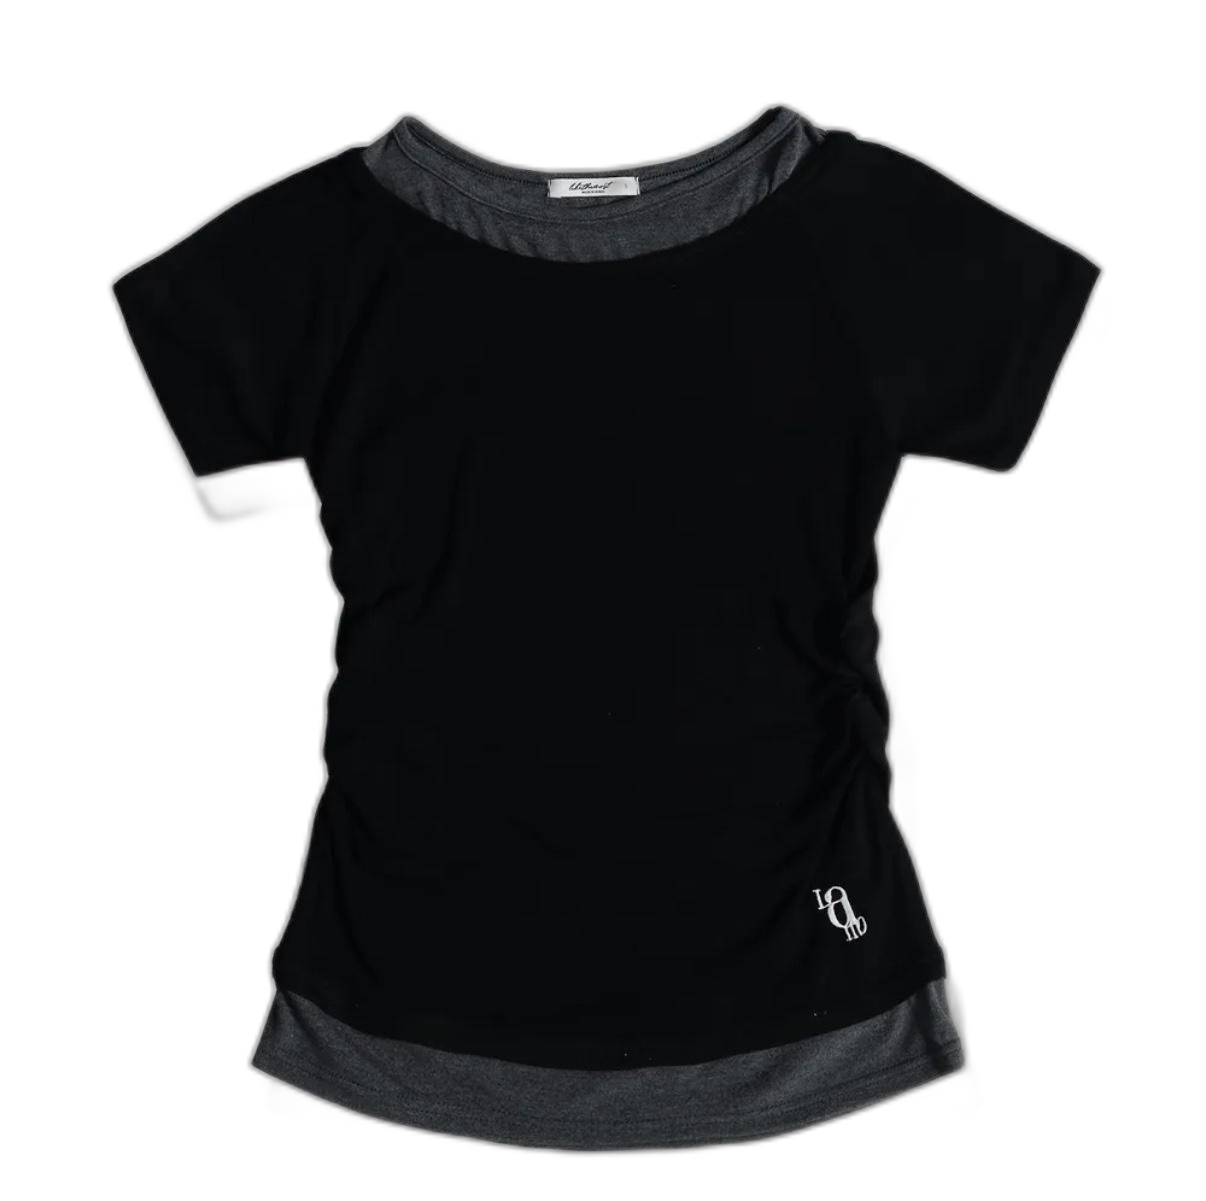

하의 누끼 결과: hpants_u2net.png


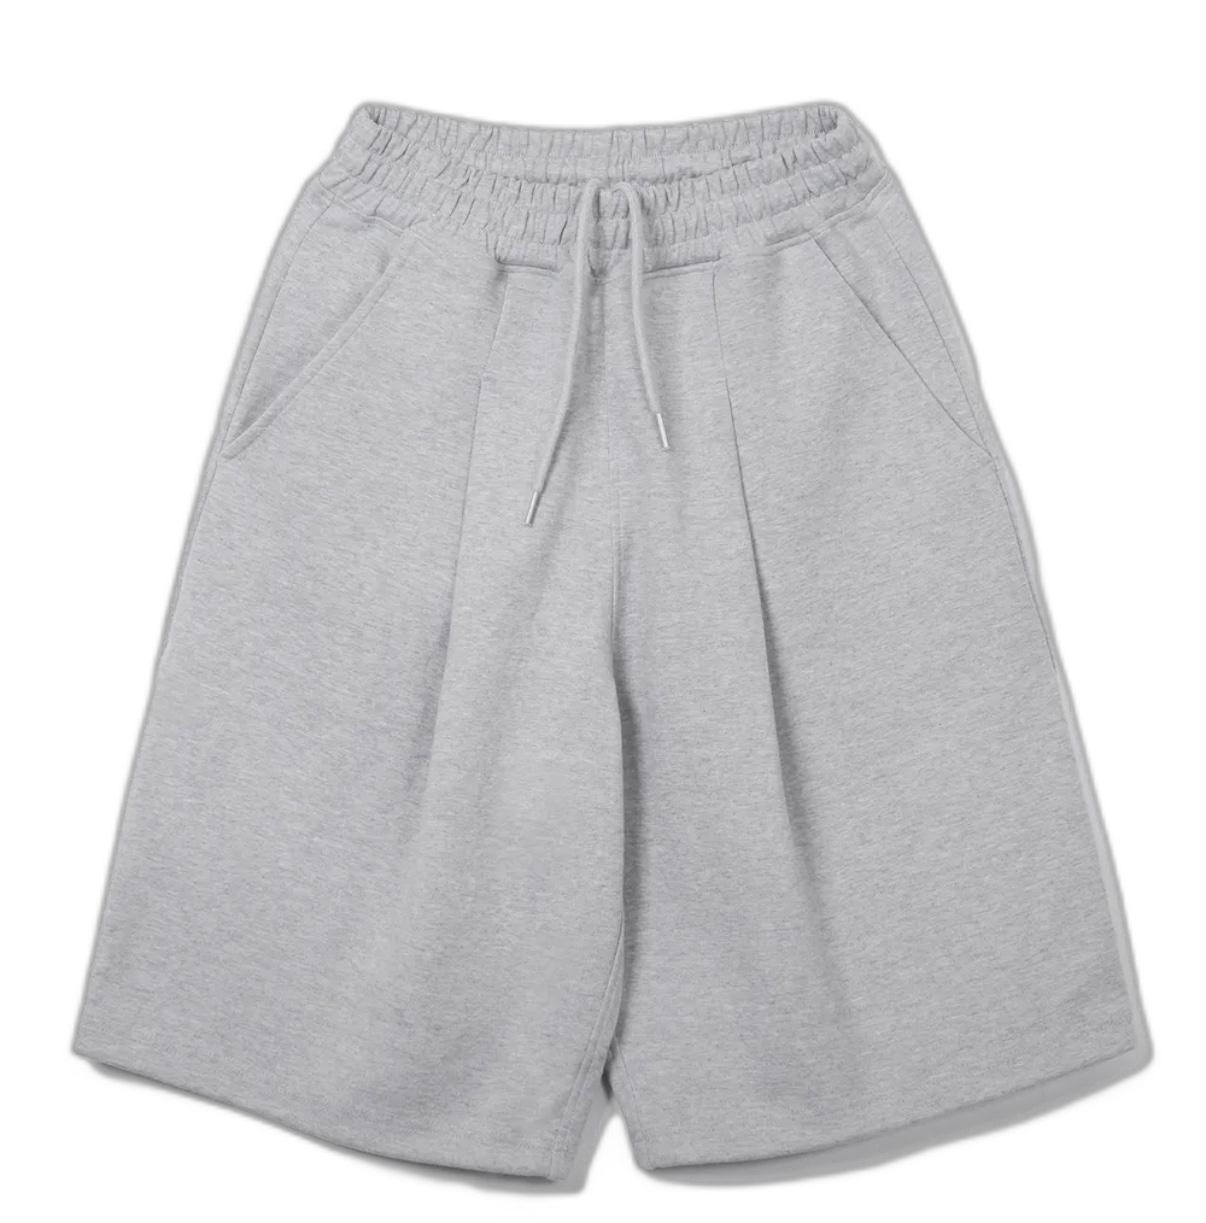

In [22]:
from PIL import Image
from IPython.display import display
import os

# 상의 확인
upper_path = "outputs/upper_clothes"
for f in os.listdir(upper_path):
    if f.endswith("_u2net.png"):
        print(f"상의 누끼 결과: {f}")
        display(Image.open(os.path.join(upper_path, f)))

# 하의 확인
lower_path = "outputs/lower_clothes"
for f in os.listdir(lower_path):
    if f.endswith("_u2net.png"):
        print(f"하의 누끼 결과: {f}")
        display(Image.open(os.path.join(lower_path, f)))

# 해당 부분까지 누끼 완료. 누끼 부분은 건드릴 것 없음. 아바타 분리 및 합성만

In [23]:
from PIL import Image
import numpy as np

def paste_centered(base, overlay, center_xy, size):
    resized = overlay.resize(size)
    cx, cy = center_xy
    w, h = resized.size
    pos = (cx - w // 2, cy - h // 2)
    base.paste(resized, pos, resized)
    return base

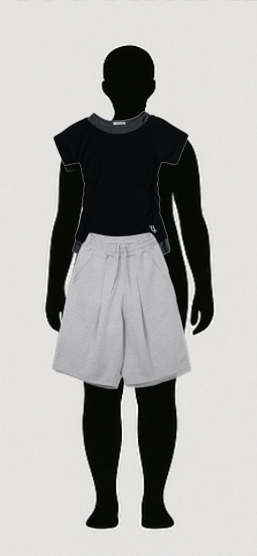

In [24]:
avatar = Image.open(avatar_path).convert("RGBA")
shirt = Image.open("outputs/upper_clothes/tshirt_u2net.png").convert("RGBA")
pants = Image.open("outputs/lower_clothes/hpants_u2net.png").convert("RGBA")

avatar = paste_centered(avatar, shirt, upper_info["center"], upper_info["size"])
avatar = paste_centered(avatar, pants, lower_info["center"], lower_info["size"])

display(avatar)